In [26]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [29]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1", "/gpu:2"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 2


In [28]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
images_subset = images[:limit]
landmarks_subset = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images_subset.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks_subset.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (100000, 224, 224, 3)
제한된 키포인트 형태: (100000, 68, 2)


### Only mouth 내곽

제한된 이미지 형태: (260399, 224, 224, 3)
제한된 키포인트 형태: (260399, 68, 2)
데이터셋 배치, 프리페치 설정 완료.
배치 이미지 형태: (32, 224, 224, 3)
배치 입 랜드마크 형태: (32, 16)


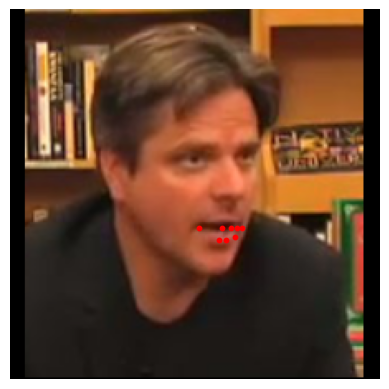

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 입술 외곽: 48번부터 59번 (총 12점)
# 입술 내곽: 60번부터 67번 (총 8점)

# 입 랜드마크 인덱스 정의 (0-based)
mouth_indices = np.arange(60, 68)  # 60번부터 67번까지

print(f'제한된 이미지 형태: {images.shape}')       # (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks.shape}') # (limit, 68, 2)

# 제너레이터 함수 정의 (입 랜드마크만 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)  # 샘플 섞기

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1, 2)  # (68, 2)
        mouth_landmarks = landmark[mouth_indices].reshape(-1)  # (20, 2) -> (40,)
        yield image, mouth_landmarks

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (입 랜드마크만 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(16,), dtype=tf.float32)  # 8 keypoints * 2 (x, y) = 16
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 셔플, 배치, 프리페치 설정
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync # 전체 배치 크기

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         # (, 224, 224, 3)
    print('배치 입 랜드마크 형태:', batch_landmarks.shape)   # (, 16)
    
    # 시각화 예시 (입 랜드마크만)
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원
    
    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.axis('off')
    plt.show()


In [16]:
# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    def create_model(input_shape=(224, 224, 3), num_keypoints=16):
        base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = True

        x = base_model.output
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1024, activation='relu')(x)
        outputs = layers.Dense(num_keypoints, activation='sigmoid')(x)  # Sigmoid 활성화 함수 적용

        model = models.Model(inputs=base_model.input, outputs=outputs)
        return model

    # 모델 정의
    model = create_model()

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='mean_squared_error',
                  metrics=['mae'])

    # 모델 요약
    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [17]:
# 학습용과 검증용 데이터셋 분리
total_samples = 100000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  


학습 데이터셋 배치 수: 2500
검증 데이터셋 배치 수: 625


In [19]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, CSVLogger
import time

# def lr_scheduler(epoch):
#     if epoch < 50:
#         return 0.001  # 첫 50 에포크 동안 학습률은 0.001
#     else:
#         return 0.0001  # 에포크 51부터 100까지 학습률은 0.0001

        
# 콜백 설정
checkpoint = ModelCheckpoint('y_mouth_v2_adam_lr0001.h5', monitor='val_loss', save_best_only=True, verbose=1)
# lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
csv_logger = CSVLogger('y_mouth_training_log.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, csv_logger]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-14 03:05:58.898436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-14 03:05:58.911178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-14 03:06:02.096023: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f34c07d0370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 03:06:02.096067: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-14 03:06:02.096073: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-14 03:06:02.096079: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-14 03:06:02.103341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH

   2500/Unknown - 302s 101ms/step - loss: 7.7406e-04 - mae: 0.0179

2024-11-14 03:10:27.066541: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2095025031068975593
2024-11-14 03:10:27.066605: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9973770128508290501
2024-11-14 03:10:27.066615: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4838382819521081561
2024-11-14 03:10:27.066624: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 113345205581435225
2024-11-14 03:10:27.066633: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3267901231215219337
2024-11-14 03:10:27.066639: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2551623400868983591
2024-11-14 03:10:27.066686: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item


Epoch 1: val_loss improved from inf to 0.00026, saving model to y_mouth_v2_adam_lr0001.h5


2024-11-14 03:11:39.990412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 113345205581435225
2024-11-14 03:11:39.990480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3267901231215219337
2024-11-14 03:11:39.990491: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7544161535666520965
2024-11-14 03:11:39.990502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12327069854809560921
2024-11-14 03:11:39.990513: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9471785543970196017
2024-11-14 03:11:39.990524: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2761049972363760091
2024-11-14 03:11:39.990563: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv ite

2500/2500 [==============================] - 376s 130ms/step - loss: 7.7406e-04 - mae: 0.0179 - val_loss: 2.6084e-04 - val_mae: 0.0125
Epoch 2/100
2500/2500 [==============================] - ETA: 0s - loss: 1.2398e-04 - mae: 0.0085
Epoch 2: val_loss improved from 0.00026 to 0.00009, saving model to y_mouth_v2_adam_lr0001.h5
2500/2500 [==============================] - 319s 128ms/step - loss: 1.2398e-04 - mae: 0.0085 - val_loss: 8.8678e-05 - val_mae: 0.0072
Epoch 3/100
2500/2500 [==============================] - ETA: 0s - loss: 7.4155e-05 - mae: 0.0065
Epoch 3: val_loss improved from 0.00009 to 0.00007, saving model to y_mouth_v2_adam_lr0001.h5
2500/2500 [==============================] - 318s 127ms/step - loss: 7.4155e-05 - mae: 0.0065 - val_loss: 7.3814e-05 - val_mae: 0.0066
Epoch 4/100
2500/2500 [==============================] - ETA: 0s - loss: 5.8442e-05 - mae: 0.0058
Epoch 4: val_loss did not improve from 0.00007
2500/2500 [==============================] - 319s 128ms/step - los

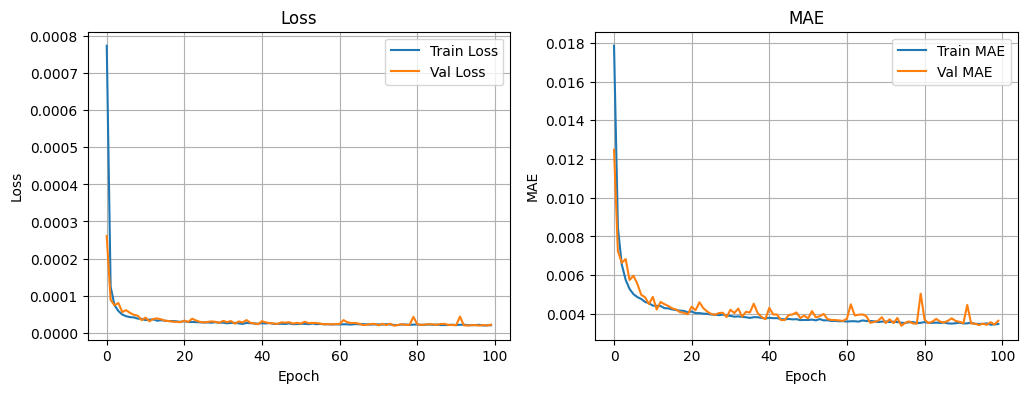

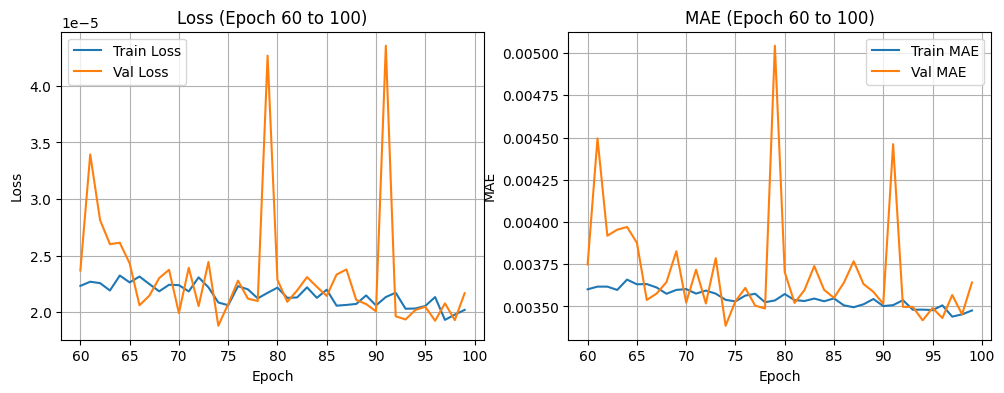

Best Epoch: 75
Minimum Validation Loss: 1.880582931335084e-05


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/y_mouth_training_log.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 60  # 시작 에포크 (0부터 시작)
end_epoch = 100   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")